## Imports

In [1]:
import numpy as np

In [2]:
import scipy as sp

In [3]:
from PIL import Image

# Lab 8
## PyVision

The purpose of this lab is to help you become more familiar with "exploratory computing," Python, Jupyter notebooks, and even a bit of Linux.  That is a lot to bight off in 1.5 hours, so let's get started!

What to do:

Execute each of the cells in order.  Do not skip any cells.  This lab is written such that things should work out if you start at the top and work your way down.  

Along the way, you will find cells which must be corrected in order to get everything to work properly.  These will be indicated with <font color='red' size='5'>Bold Red Text</font>

## Understanding Images

Computer images can come in a variety of formats, but the most common is that of a dense RGB Array.  For an image which is $n+1$ pixels wide and $m+1$ pixels tall, this would look something like:
```
[[[r00, g00, b00], [r01, g01, b01], ... , [r0n, g0n, b0n]],
 [[r10, g10, b10], [r11, g11, b11], ... , [r1n, g1n, b1n]],
 ...
 [[rm0, gm0, bm0], [rm1, gm1, bm1], ... , [rmn, gmn, bmn]]]
 ```
 

Note that the $(0, 0)$ pixels is in the upper-left hand corner.  The pixels fill in the same way you would write words on the page.  Similar to matrices, we describe the size of such a matrix by starting at the outside and working our way in.  The size of the above array would be `(m,n,3)`.

Additionally, most computer monitors operate in 8-bit scale, meaning that the red value of a pixel can have values in the range [0, ..., 255].  Why 255?  Because $2^8 - 1 = 255$.

Let us begin by creating an array of zeros representing an image which is {H,W} = {150, 200}.

In [12]:
testImageData = np.zeros(shape=(150, 200, 3), dtype=np.uint8)

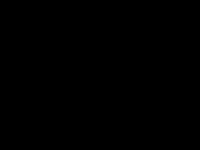

In [13]:
Image.fromarray(testImageData)

We can use our Numpy indexing skills to alter this image.  For instance, let's put a red box in the middle.

In [14]:
testImageData[75-20:75+20, 100-20:100+20] = [255, 0, 0]

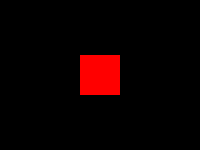

In [15]:
Image.fromarray(testImageData)

Ok... your turn!  

<font color='red' size='5'>Alter the cell below to:</font> 
* Put a blue box in the upper-left hand corner
* Put a green box in the lower-right hand corner
* Put a white box in the upper-right hand corner
* Put a red disk in the center


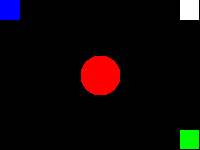

In [39]:
testImageData[:, :] = [0, 0, 0]
testImageData[0:20, 0:20] = [0, 0, 255]
testImageData[130:150-1, 180:200-1] = [0, 255, 0]
testImageData[0:20, 180:200-1] = [255, 255, 255]
for x in range(200):
    for y in range(150):
        if (x-100)**2 + (y-75)**2 < 20**2:
            testImageData[y, x] = [255, 0, 0]
Image.fromarray(testImageData)

Let's see if we can look for only the red objects in the image.  We're going to do this by dividing the image up into three color channels (red, green, blue) and then calculating a color distance for each pixel.  We'll borrow the typical distance formula from geometry $d = \sqrt{((x_e - x_s)^2 + (y_e - y_s)^2 + (z_e - z_s)^2}$, but in this case, we'll use the colors as coordinates.

In [126]:
def computeColorDistance(imageData, rgbTargetColor):
    rVal, gVal, bVal = rgbTargetColor     # break the targetColor up into it's red, gree, and blue values
    rCh = imageData[:,:,0]                # separate the red channel from the image. (m,n) of 'uint8'.
    gCh = imageData[:,:,1]                #              green
    bCh = imageData[:,:,2]                #              blue
    rDist = (rCh - rVal)/255.             # compute the "red distance" and normalize to one.  (m,n) of 'float' in [0, 1]
    gDist = (gCh - gVal)/255.             #             "green distance" 
    bDist = (bCh - bVal)/255.             #             "blue distance" 
                                          # Compute the normalized distance.  (m, n) 'float' in [0, 1]
    colorDist = ((rDist**2 + gDist**2 + bDist**2)**0.5) / ((3)**0.5)
    return colorDist

In [123]:
testImageData1 = np.array([[[0, 0, 0]]], 'uint8')
computeColorDistance(testImageData1, [255, 255, 255])

array([[0.00392157]])

In [113]:
lum = np.clip(colorDist*256, 0, 255).astype('uint8')
rgbData = np.dstack((lum, lum, lum))

In [114]:
rgbData

array([[[209, 209, 209],
        [209, 209, 209],
        [209, 209, 209],
        ...,
        [209, 209, 209],
        [209, 209, 209],
        [147, 147, 147]],

       [[209, 209, 209],
        [209, 209, 209],
        [209, 209, 209],
        ...,
        [209, 209, 209],
        [209, 209, 209],
        [147, 147, 147]],

       [[209, 209, 209],
        [209, 209, 209],
        [209, 209, 209],
        ...,
        [209, 209, 209],
        [209, 209, 209],
        [147, 147, 147]],

       ...,

       [[147, 147, 147],
        [147, 147, 147],
        [147, 147, 147],
        ...,
        [209, 209, 209],
        [209, 209, 209],
        [147, 147, 147]],

       [[147, 147, 147],
        [147, 147, 147],
        [147, 147, 147],
        ...,
        [209, 209, 209],
        [209, 209, 209],
        [147, 147, 147]],

       [[147, 147, 147],
        [147, 147, 147],
        [147, 147, 147],
        ...,
        [147, 147, 147],
        [147, 147, 147],
        [147, 147, 147]]

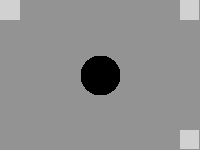

In [110]:
Image.fromarray(rgbData)

We begin by creating a `camera` object.

We can change various properties of the camera such as the resolution and frame rate.

We need a place to put the data.  A Numpy array is particularly well suited for this because it is a dense array.  If it is the proper shape andhe data can be directly transThe numpy array must match the size of the incoming array exactly, or else weird things happen.  Note that this is a color camera, so each pixel has an RGB (Red, Green, Blue) value.

In [9]:
dataholder = np.zeros(shape=(10,8,3), dtype=np.uint8)